In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from pathlib import Path
import tqdm
from dataclasses import dataclass
import time
from datetime import datetime

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F

def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip uninstall agroqualifier -y

Found existing installation: agroqualifier 0.1
Uninstalling agroqualifier-0.1:
  Successfully uninstalled agroqualifier-0.1


In [3]:
# !pip install git+https://@github.com/shallex/agroqualifier.git
!pip install wandb

# Crop Dataset

## Test

In [ ]:
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git
from lang_sam import LangSAM

  Cloning https://github.com/luca-medeiros/lang-segment-anything.git to /tmp/pip-req-build-a1k_sads
  Running command git clone --filter=blob:none --quiet https://github.com/luca-medeiros/lang-segment-anything.git /tmp/pip-req-build-a1k_sads
  Resolved https://github.com/luca-medeiros/lang-segment-anything.git to commit 831cdc10906a23aabe4591a4be06f4c989e4ee30
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-install-ep31u_lw/groundingdino_9d5cbf5e18004b16999d2d0e76f841c2
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-install-ep31u_lw/groundingdino_9d5cbf5e18004b16999d2d0e76f841c2
  Resolved https://github.com/IDEA-Research/GroundingDINO.git to commit 16e0ccdb7da40613591666abe2cb06f91f961503
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/fac

In [ ]:
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

In [ ]:
model = LangSAM()
image_pil = Image.open("2024-03-14 18:51:58.361526.png").convert("RGB")
text_prompt = "mandarin"
masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:14<00:00, 182MB/s]
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.wa

In [ ]:
print_bounding_boxes(boxes)

Bounding Boxes:
Box 1: tensor([ 225.0022,  765.4800,  552.1116, 1030.6552])
Box 2: tensor([ 550.4935,  788.4086,  752.7982, 1004.0515])
Box 3: tensor([ 950.6475,  789.1759, 1205.5977, 1061.4535])
Box 4: tensor([1392.2854,  828.0313, 1616.4078, 1047.9584])


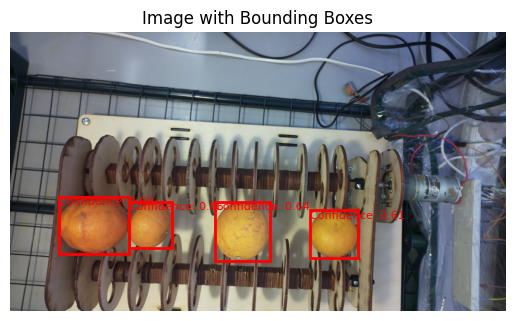

In [ ]:
display_image_with_boxes(image_pil, boxes, logits)

In [ ]:
image_pil._size

(2304, 1296)

In [ ]:
box = boxes[0]
box

tensor([ 225.0022,  765.4800,  552.1116, 1030.6552])

In [ ]:
x_min, y_min, x_max, y_max = box.numpy()
x_min

225.00217

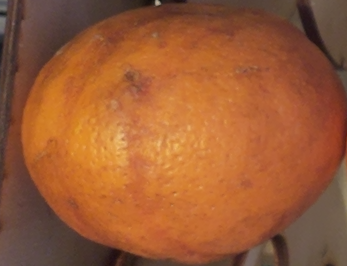

In [ ]:
cropped_image = image_pil.crop((x_min - 20, y_min, x_max, y_max))
cropped_image

In [ ]:
cropped_image.save("cropped_mandarin_1.png")

## Crop dataset

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
def crop_save_image(image, img_path, boxes):
  if (len(boxes) == 4) or (len(boxes) == 3 and img_path.parent.name in ["NO_IR_Healthy", "Infra_Red_Healthy"]):
    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box.numpy()
        cropped_image = image.crop((x_min - 20, y_min - 20, x_max + 20, y_max + 20))

        new_path = f"/content/drive/MyDrive/Датасеты/Мандарины/cropped_mandarins/{img_path.parent.name}/{img_path.stem}_{i}.png"
        cropped_image.save(new_path)
  else:
    print(f"\n[Warning] Image {img_path} has {len(boxes)} boxes\n")
    return img_path
  return None

def crop_dataset(dir_path: Path, model, text_prompt):
  bad_paths = []
  for subdir in dir_path.iterdir():
    if subdir.is_dir():
      print(subdir)
      for image_path in tqdm.tqdm(list(subdir.glob("*.png"))):
        new_path = Path(f"/content/drive/MyDrive/Датасеты/Мандарины/cropped_mandarins/{image_path.parent.name}/{image_path.stem}_2.png")
        if new_path.exists():
          continue
        image_pil = Image.open(image_path).convert("RGB")

        masks, boxes, _, _ = model.predict(image_pil, text_prompt)
        bad_img_path = crop_save_image(image_pil, image_path, boxes)
        if bad_img_path is not None:
          bad_paths.append(bad_img_path)
  return bad_paths

# model = LangSAM()
text_prompt = "mandarin"
dir_path = Path("/content/drive/MyDrive/Датасеты/Мандарины/mandarin")

bad_paths = crop_dataset(dir_path, model, text_prompt)


/content/drive/MyDrive/Датасеты/Мандарины/mandarin/Infra_Red_damaged


100%|██████████| 256/256 [00:00<00:00, 2997.70it/s]


/content/drive/MyDrive/Датасеты/Мандарины/mandarin/NO_IR_Healthy


100%|██████████| 262/262 [00:00<00:00, 2157.79it/s]


/content/drive/MyDrive/Датасеты/Мандарины/mandarin/Infra_Red_Healthy


  0%|          | 0/262 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 262/262 [02:10<00:00,  2.01it/s]


/content/drive/MyDrive/Датасеты/Мандарины/mandarin/NO_IR_damaged


100%|██████████| 256/256 [11:20<00:00,  2.66s/it]


In [ ]:
len(bad_paths)

In [ ]:
len(list(Path("/content/drive/MyDrive/Датасеты/Мандарины/cropped_mandarins/NO_IR_damaged").glob("*.png")))

1024

# Dataset info

In [3]:
dates = {}

dir = Path("/content/drive/MyDrive/Датасеты/Мандарины/cropped_mandarins/")
for subdir in dir.iterdir():
  for img_path in subdir.glob("*.png"):
    name = img_path.stem
    date = name.split(" ")[0]
    if dates.get(date):
      dates[date] += 1
    else:
      dates[date] = 1

dates

{'2024-03-14': 1856,
 '2024-03-29': 312,
 '2024-03-30': 568,
 '2024-04-04': 128,
 '2024-04-05': 560,
 '2024-04-06': 630}

In [6]:
dates_full = dates.copy()

In [7]:


dates = {}

dir = Path("/content/drive/MyDrive/Датасеты/Мандарины/cropped_mandarins/Infra_Red_damaged")

for img_path in dir.glob("*.png"):
  name = img_path.stem
  date = name.split(" ")[0]
  if dates.get(date):
    dates[date] += 1
  else:
    dates[date] = 1

dates


{'2024-03-14': 60,
 '2024-03-29': 156,
 '2024-03-30': 284,
 '2024-04-04': 64,
 '2024-04-05': 280,
 '2024-04-06': 180}

In [12]:
s = "2024-03-30 06:20:38.713108"

# 2024-03-30 06:26:35.306508

In [19]:
from datetime import datetime

date_str1 = "2024-03-30 06:20:38.713108"
date_str2 = "2024-03-30 06:26:35.306508"

date_format = "%Y-%m-%d %H:%M:%S.%f"
date1 = datetime.strptime(date_str1, date_format)
date2 = datetime.strptime(date_str2, date_format)

date1 < date2

True

In [23]:
(date2 - date1).seconds / (60 * 60)

0.09888888888888889

In [ ]:
mandarin_tries = {
    1: "2024-03-14 18:51:58.361526",
    2: "2024-03-30 06:26:35.306508",
    3: "2024-04-04 19:40:13.735124",
    4: "2024-04-05 10:42:12.116010"
}

## Work with Dataset

### Binary Classification dataset

In [ ]:
class MandarinDataset(Dataset):
  def __init__(
      self,
      data_dir: Path,
      original_light: bool,
      IR_lamp_light: bool,
      train: bool,
      size=(300, 300),
      transform=None
  ):
    """Mandarin Dataset.

    Arguments:
      data_dir: Path - path to dataset directory, contained 4 folders with images
      original_light: bool - whether to use images made without Infra-Red lamp, only environmental light
      IR_lamp_light: bool - whether to use images made with Infra-Red lamp
      train: bool - is it train dataset or not, at train dataset use augmentations
      size: Tuple[int] - size for resizing images
      transform: training augmentation transforms
    """
    assert original_light or IR_lamp_light
    self.original_light = original_light
    self.IR_lamp_light = IR_lamp_light
    self.data_dir = data_dir
    self.resize = transforms.Resize(size)
    self.train = train
    self.transform = transform

    self.subdirs = {subdir.name: subdir for subdir in data_dir.iterdir() if subdir.is_dir()}
    self.subdirs_names = list(self.subdirs.keys())

    assert len(self.subdirs) == 4
    self.subdir_images_paths = {}

    for subdir_name, subdir in self.subdirs.items():
      self.subdir_images_paths[subdir_name] = list(subdir.glob("*.png"))

    self.images_paths = {"original_light": [], "IR_lamp_light": []}

    for subdir_name in self.subdirs_names:
      if subdir_name.startswith("Infra"):
        self.images_paths["IR_lamp_light"].extend(self.subdir_images_paths[subdir_name])

    for img_path in self.images_paths["IR_lamp_light"]:
      subdir = img_path.parent
      original_lamp_path = subdir.parent / f"NO_IR_{subdir.name.split('_')[-1]}" / img_path.name
      assert original_lamp_path.exists()
      self.images_paths["original_light"].append(original_lamp_path)

    for i in range(len(self.images_paths["original_light"])):
      assert self.images_paths["original_light"][i].name == self.images_paths["IR_lamp_light"][i].name

  def __len__(self):
    return len(self.images_paths["original_light"])

  def __getitem__(self, idx):
    if self.original_light:
      image = Image.open(self.images_paths["original_light"][idx]).convert("RGB")
      is_damaged = self.images_paths["original_light"][idx].parent.name.endswith("damaged")
      image = transforms.functional.pil_to_tensor(image)
      image = self.resize(image)

    if self.IR_lamp_light:
      ir_image = Image.open(self.images_paths["IR_lamp_light"][idx]).convert("RGB")
      is_damaged = self.images_paths["original_light"][idx].parent.name.endswith("damaged")
      ir_image = transforms.functional.pil_to_tensor(ir_image)
      ir_image = self.resize(ir_image)

    if self.original_light and self.IR_lamp_light:
      image = torch.cat((image, ir_image))
    elif not self.original_light and self.IR_lamp_light:
      image = ir_image

    # TODO: idk can we apply transforms to 6 channels image or not?
    if self.transform and self.train:
        image = self.transform(image)

    return image, torch.as_tensor(is_damaged).long()

### Predict time of spoil

In [2]:
date_format = "%Y-%m-%d %H:%M:%S.%f"

class MandarinDatasetTime(Dataset):
  def __init__(
      self,
      data_dir: Path,
      original_light: bool,
      IR_lamp_light: bool,
      train: bool,
      size=(300, 300),
      transform=None
  ):
    """Mandarin Dataset.

    Arguments:
      data_dir: Path - path to dataset directory, contained 4 folders with images
      original_light: bool - whether to use images made without Infra-Red lamp, only environmental light
      IR_lamp_light: bool - whether to use images made with Infra-Red lamp
      train: bool - is it train dataset or not, at train dataset use augmentations
      size: Tuple[int] - size for resizing images
      transform: training augmentation transforms
    """
    assert original_light or IR_lamp_light
    self.original_light = original_light
    self.IR_lamp_light = IR_lamp_light
    self.data_dir = data_dir
    self.resize = transforms.Resize(size)
    self.train = train
    self.transform = transform

    self.mandarin_tries = {
        1: "2024-03-14 18:51:58.361526",
        2: "2024-03-30 06:26:35.306508", # "2024-04-04 19:40:13.735124" - перестановка
        3: "2024-04-05 10:42:12.116010"
    }

    self.subdirs = {subdir.name: subdir for subdir in data_dir.iterdir() if subdir.is_dir()}
    self.subdirs_names = list(self.subdirs.keys())

    assert len(self.subdirs) == 4
    self.subdir_images_paths = {}

    for subdir_name, subdir in self.subdirs.items():
      self.subdir_images_paths[subdir_name] = list(subdir.glob("*.png"))

    self.images_paths = {"original_light": [], "IR_lamp_light": []}

    for subdir_name in self.subdirs_names:
      if subdir_name.startswith("Infra"):
        self.images_paths["IR_lamp_light"].extend(self.subdir_images_paths[subdir_name])

    for img_path in self.images_paths["IR_lamp_light"]:
      subdir = img_path.parent
      original_lamp_path = subdir.parent / f"NO_IR_{subdir.name.split('_')[-1]}" / img_path.name
      assert original_lamp_path.exists()
      self.images_paths["original_light"].append(original_lamp_path)

    for i in range(len(self.images_paths["original_light"])):
      assert self.images_paths["original_light"][i].name == self.images_paths["IR_lamp_light"][i].name

  def __len__(self):
    return len(self.images_paths["original_light"])

  def _get_lay_time(self, image_path):
    if image_path.parent.name.endswith("damaged"):
      date = image_path.stem.split("_")[0]
      date = datetime.strptime(date, date_format)

      num_try = len(self.mandarin_tries)
      for i in range(2, len(self.mandarin_tries) + 1):
        start_date = datetime.strptime(self.mandarin_tries[i], date_format)
        if date < start_date:
          num_try = i - 1
          break

      start_date = datetime.strptime(self.mandarin_tries[num_try], date_format)
      diff = (date - start_date).seconds / (60 * 60)
      return diff

    else:
      return 0

  def __getitem__(self, idx):
    if self.original_light:
      image = Image.open(self.images_paths["original_light"][idx]).convert("RGB")

      lay_time_hours = self._get_lay_time(self.images_paths["original_light"][idx])

      image = transforms.functional.pil_to_tensor(image)
      image = self.resize(image)

    if self.IR_lamp_light:
      ir_image = Image.open(self.images_paths["IR_lamp_light"][idx]).convert("RGB")

      lay_time_hours = self._get_lay_time(self.images_paths["IR_lamp_light"][idx])

      ir_image = transforms.functional.pil_to_tensor(ir_image)
      ir_image = self.resize(ir_image)

    if self.original_light and self.IR_lamp_light:
      image = torch.cat((image, ir_image))
    elif not self.original_light and self.IR_lamp_light:
      image = ir_image

    # TODO: idk can we apply transforms to 6 channels image or not?
    if self.transform and self.train:
        image = self.transform(image)

    return image, torch.as_tensor(lay_time_hours).float()

## Params

In [3]:
@dataclass
class DatasetParams:
  data_dir = Path("/content/drive/MyDrive/Датасеты/Мандарины/cropped_mandarins")
  original_light = True
  IR_lamp_light = False
  mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

  train_transforms = transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.Normalize(mean=mean, std=std),
  ])
  size = (300, 300)
  val_ratio = 0.1
  test_ratio = 0.1


@dataclass
class TrainingParams:
  num_epochs = 10
  l_rate = 1e-3
  train_batch_size = 32
  val_batch_size = 16
  test_batch_size = 16
  device = "cuda"

  criterion = nn.CrossEntropyLoss()
  optimizer = "Adam"
  optimimzer_kwargs = {}
  scheduler = "StepLR"

  scheduler_kwargs = {"step_size": 30, "gamma": 0.1}


@dataclass
class ModelParams:
  architecture = "SimpleCNN"
  input_channels = 3
  output_channels = 2


@dataclass
class Params:
  problem_type: str = "binary_classification"
  dataset_params = DatasetParams()
  training_params = TrainingParams()
  model_params = ModelParams()




class Sasha_Exp_1(Params):
  def __init__(self):
    super().__init__()
    self.dataset_params.train_transforms = None

class Sasha_Exp_2(Params):
  def __init__(self):
    super().__init__()
    self.dataset_params.train_transforms = None
    self.training_params.num_epochs = 5


class Sasha_Exp_1_time_pred(Params):
  def __init__(self):
    super().__init__()
    self.problem_type = "time_prediction"
    self.dataset_params.train_transforms = None
    self.training_params.criterion = nn.MSELoss()
    self.model_params.output_channels = 1
    self.training_params.num_epochs = 5


## Model

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, params):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(params.model_params.input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.flatten_size = (32 * params.dataset_params.size[0] * params.dataset_params.size[1]) // (4 ** 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, params.model_params.output_channels)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
from torch.optim.lr_scheduler import StepLR

models_dict = {"SimpleCNN": SimpleCNN}

optimizer_dict = {"Adam": torch.optim.Adam}

scheduler_dict = {"StepLR": StepLR}

def get_loaders(params, dataset_class):
    """Get dataloader for MandarinDataset."""
    dataset = dataset_class(
        params.dataset_params.data_dir,
        params.dataset_params.original_light,
        params.dataset_params.IR_lamp_light,
        train=True,
        size=params.dataset_params.size,
        transform=params.dataset_params.train_transforms)

    val_size = int(params.dataset_params.val_ratio * len(dataset))
    test_size = int(params.dataset_params.test_ratio * len(dataset))
    train_size = len(dataset) - val_size - test_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    val_dataset.train = False
    test_dataset.train = False

    train_loader = DataLoader(train_dataset, batch_size=params.training_params.train_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params.training_params.val_batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params.training_params.test_batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def get_model(params):
  model = models_dict[params.model_params.architecture](params)
  return model

def get_optimizer(params, model):
  return optimizer_dict[params.training_params.optimizer](
      model.parameters(),
      lr=params.training_params.l_rate,
      **params.training_params.optimimzer_kwargs)

def get_scheduler(params, optimizer):
  scheduler = scheduler_dict[params.training_params.scheduler](optimizer, **params.training_params.scheduler_kwargs)
  return scheduler

In [6]:
exp_param = Sasha_Exp_1_time_pred()

In [7]:
import wandb

# 3a2e396ef1adf8592f1ff3729e4725f92f07d806

wandb.login()

wandb: Currently logged in as: sharshavin. Use `wandb login --relogin` to force relogin


True

In [17]:
# from agroqualifier.trainer import Trainer
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import tqdm
import random

import wandb


class Trainer:
    def __init__(
        self,
        model,
        params,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler=None,
        device: str = "cuda",
        wandb_logging=False,
    ):
        self.model = model.to(device)
        self.params = params
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.wandb_logging = wandb_logging

        if wandb_logging:
            wandb.init(
                project="AgroQualifier",
                name=self.params.__class__.__name__,
                config={
                    "learning_rate": self.params.training_params.l_rate,
                    "architecture": self.params.model_params.architecture,
                    "dataset": (f"Use original_light, " if self.params.dataset_params.original_light else "")
                    + (f"Use IR_lamp_light" if self.params.dataset_params.IR_lamp_light else ""),
                    "epochs": self.params.training_params.num_epochs,
                },
            )

    def set_global_seed(self, seed: int) -> None:
        """
        Set global seed for reproducibility.
        """

        random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True

    def train(self):
        self.set_global_seed(42)
        for epoch in range(self.params.training_params.num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm.tqdm(self.train_loader, desc=f"Train loop, Epoch {epoch + 1}"):
                inputs, labels = inputs.to(self.device).float(), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                if self.params.problem_type == "time_prediction":
                  outputs = outputs.squeeze(-1)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                if self.params.problem_type == "binary_classification":
                  _, predicted = torch.max(outputs, 1)
                  correct += (predicted == labels).sum().item()
                  total += labels.size(0)
                else:
                  total = 1

            accuracy = correct / total
            training_loss = running_loss / len(self.train_loader)
            print(f"Epoch {epoch+1}/{self.params.training_params.num_epochs}, Training Accuracy: {accuracy}, Training Loss: {training_loss}")
            if self.wandb_logging:
                wandb.log({"Train/loss": training_loss, "Train/accuracy": accuracy, "Learning rate": self.get_lr()})

            if self.scheduler is not None:
                self.scheduler.step()

            self.evaluate()

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm.tqdm(self.val_loader, desc="Validation loop"):
                inputs, labels = inputs.to(self.device).float(), labels.to(self.device)

                outputs = self.model(inputs)
                if self.params.problem_type == "time_prediction":
                  outputs = outputs.squeeze(-1)
                val_loss += self.criterion(outputs, labels).item()

                if self.params.problem_type == "binary_classification":
                  _, predicted = torch.max(outputs, 1)
                  correct += (predicted == labels).sum().item()
                  total += labels.size(0)
                else:
                  total = 1

        accuracy = correct / total
        val_loss = val_loss / len(self.val_loader)
        if self.wandb_logging:
            wandb.log({"Validation/loss": val_loss, "Validation/accuracy": accuracy})
        print(f"Validation Accuracy: {accuracy}, Validation loss: {val_loss}")

    def get_lr(self):
        for param_group in self.optimizer.param_groups:
            return param_group['lr']

    def test(self, test_loader):
        self.model.eval()
        correct = 0
        total = 0
        test_loss = 0.0
        y_preds = []
        y_true = []
        with torch.no_grad():
            for inputs, labels in tqdm.tqdm(test_loader, desc="Validation loop"):
                inputs, labels = inputs.to(self.device).float(), labels.to(self.device)

                outputs = self.model(inputs)
                if self.params.problem_type == "time_prediction":
                  outputs = outputs.squeeze(-1)
                test_loss += self.criterion(outputs, labels).item()

                if self.params.problem_type == "binary_classification":
                  _, predicted = torch.max(outputs, 1)
                  y_preds.extend(list(predicted.cpu().numpy()))
                  y_true.extend(list(labels.cpu().numpy()))

                  correct += (predicted == labels).sum().item()
                  total += labels.size(0)
                else:
                  total = 1

        accuracy = correct / total
        test_loss = test_loss / len(test_loader)
        if self.wandb_logging:
            wandb.log({"Test/loss": test_loss, "Test/accuracy": accuracy})
        print(f"\nTest Accuracy: {accuracy}, Test loss: {test_loss}")
        return y_preds, y_true


In [18]:
set_global_seed(42)

In [19]:
train_loader, val_loader, test_loader = get_loaders(exp_param, dataset_class=MandarinDatasetTime)

In [20]:
model = get_model(exp_param)
optimizer = get_optimizer(exp_param, model)
scheduler = get_scheduler(exp_param, optimizer)

In [21]:
trainer = Trainer(model, exp_param, train_loader, val_loader, exp_param.training_params.criterion, optimizer, scheduler,
                  device="cuda",
                  wandb_logging=True)

Learning rate,▁▁▁▁▁
Train/accuracy,▁▁▁▁▁
Train/loss,█▁▁▁▁
Validation/accuracy,▁▁▁▁▁
Validation/loss,▃█▁▁▁
Learning rate,0.001
Train/accuracy,0.0
Train/loss,52.91667
Validation/accuracy,0.0
Validation/loss,51.61768


In [22]:
trainer.train()

Train loop, Epoch 1: 100%|██████████| 51/51 [00:27<00:00,  1.84it/s]


Epoch 1/5, Training Accuracy: 0.0, Training Loss: 746535.6001594767


Validation loop: 100%|██████████| 13/13 [00:02<00:00,  5.17it/s]


Validation Accuracy: 0.0, Validation loss: 49.49180661714994


Train loop, Epoch 2: 100%|██████████| 51/51 [00:22<00:00,  2.27it/s]


Epoch 2/5, Training Accuracy: 0.0, Training Loss: 58.73065376281738


Validation loop: 100%|██████████| 13/13 [00:02<00:00,  5.84it/s]


Validation Accuracy: 0.0, Validation loss: 50.918755751389725


Train loop, Epoch 3: 100%|██████████| 51/51 [00:23<00:00,  2.14it/s]


Epoch 3/5, Training Accuracy: 0.0, Training Loss: 34.3968599356857


Validation loop: 100%|██████████| 13/13 [00:02<00:00,  5.74it/s]


Validation Accuracy: 0.0, Validation loss: 34.39016386178824


Train loop, Epoch 4: 100%|██████████| 51/51 [00:22<00:00,  2.30it/s]


Epoch 4/5, Training Accuracy: 0.0, Training Loss: 29.63587833853329


Validation loop: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]


Validation Accuracy: 0.0, Validation loss: 35.32142844566932


Train loop, Epoch 5: 100%|██████████| 51/51 [00:21<00:00,  2.34it/s]


Epoch 5/5, Training Accuracy: 0.0, Training Loss: 31.831603405522365


Validation loop: 100%|██████████| 13/13 [00:02<00:00,  4.73it/s]

Validation Accuracy: 0.0, Validation loss: 29.093877205481895


# Test

## Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def display_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
y_preds, y_true = trainer.test(test_loader)

Validation loop: 100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

Test Accuracy: 0.9603960396039604, Test loss: 0.4649033484210332


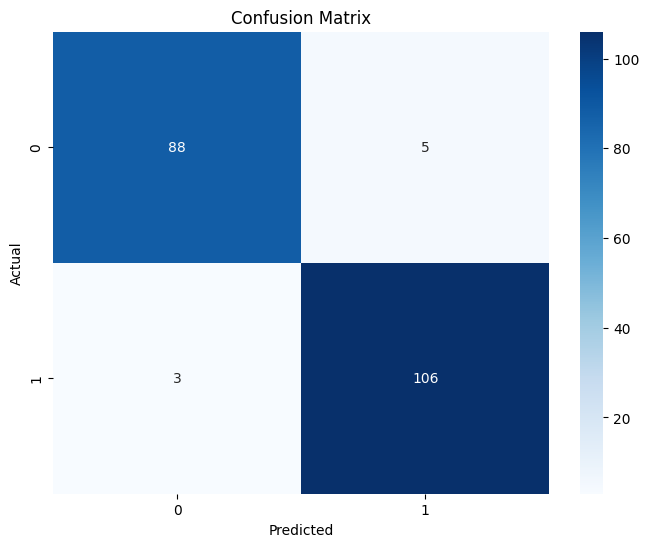

In [ ]:
display_confusion_matrix(y_true, y_preds, labels=[0, 1])

In [ ]:
sample = next(iter(test_loader))
img = sample[0]
img.shape

torch.Size([16, 3, 300, 300])

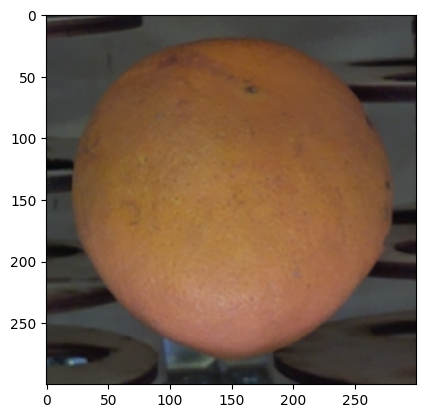

In [ ]:
plt.imshow(img[0].transpose(0,2))

## look at preds

In [39]:
c = 0
for sample in iter(test_loader):
  if c == 1:
    break
  c += 1

sample[1]

tensor([12.4997,  0.0000,  0.0000,  5.3500,  0.0000,  1.6686, 17.4186, 13.8614,
         0.0000,  0.0000,  0.0000, 16.3639,  0.0000,  1.6686,  0.0000,  4.6778])

In [40]:
inputs = sample[0].to("cuda").float()

tensor([[[[132., 132., 132.,  ..., 100., 100., 100.],
          [131., 132., 132.,  ..., 101., 101., 100.],
          [131., 132., 132.,  ..., 100., 101.,  99.],
          ...,
          [ 92.,  93.,  93.,  ...,  59.,  54.,  48.],
          [ 92.,  92.,  93.,  ...,  59.,  54.,  49.],
          [ 93.,  93.,  93.,  ...,  64.,  62.,  60.]],

         [[146., 147., 147.,  ..., 100.,  98.,  96.],
          [146., 147., 147.,  ..., 100.,  99.,  97.],
          [147., 148., 148.,  ..., 101.,  99.,  98.],
          ...,
          [ 98.,  99., 100.,  ...,  52.,  48.,  43.],
          [ 99.,  99.,  99.,  ...,  52.,  47.,  44.],
          [ 99., 100., 100.,  ...,  58.,  56.,  56.]],

         [[129., 129., 130.,  ...,  78.,  76.,  74.],
          [129., 129., 130.,  ...,  78.,  77.,  75.],
          [129., 130., 130.,  ...,  79.,  77.,  75.],
          ...,
          [ 83.,  84.,  84.,  ...,  39.,  39.,  38.],
          [ 83.,  84.,  84.,  ...,  37.,  36.,  38.],
          [ 84.,  84.,  85.,  ...

In [41]:
out = trainer.model(inputs).squeeze(-1)
out

tensor([14.6898, 10.0316,  0.8977,  8.8999,  8.5073,  3.6284, 10.1315,  6.4235,
         3.2961,  0.6410, 10.1536,  8.6143,  0.1149,  2.7523,  0.7298,  2.8681],
       device='cuda:0', grad_fn=<SqueezeBackward1>)

In [33]:
target = sample[1]
target

tensor([ 9.4881,  9.6714,  0.0000,  0.0000,  0.0000, 18.4975, 11.4914,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 24.9822,  0.0000])

In [36]:
out = out.squeeze(-1)
out

tensor([ 9.7362,  8.6842,  8.5394,  0.8274,  0.5673, 11.5302, 14.7245,  4.2393,
         0.2725,  1.9328,  2.4984,  1.0597,  2.6646,  0.6006, 11.0220,  0.9245],
       device='cuda:0', grad_fn=<SqueezeBackward1>)